# Imports

This notebooks was run on colab due to technical limitations.

Please place data_for_classification.csv into the same directory.

In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn import svm
from sklearn.metrics import accuracy_score, recall_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.utils import compute_class_weight, resample
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_validate
from sklearn.base import clone, BaseEstimator
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.validation import check_is_fitted
from sklearn.exceptions import NotFittedError
from sklearn.datasets import make_classification

from functools import wraps
from xgboost import XGBClassifier
import lightgbm as lgb

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

import time

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
!pip install ipympl

In [ ]:
%matplotlib widget

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

# Function block

In [ ]:
def plot_feature_vs_target(df, feature_col, target_col, title="long", ax=None, **params):
  """
  Plots the distribution of a feature vs the target column.
  """
  assert isinstance(df, pd.DataFrame)
  assert feature_col in df.columns
  assert target_col in df.columns

  if ax is None:
    print("Creating new figure")
    fig, ax = plt.subplots()
  sns.histplot(data=df, x=feature_col, hue=target_col, multiple='dodge', ax=ax, **params);
  if title=="short":
    ax.set_title(f"{feature_col}")
  else:
    ax.set_title(f"{feature_col} vs {target_col}")

In [ ]:
def plot_violin(df, feature_col_1, feature_col_2, target_col):
  """
  Plots violin plots to compare two features vs the target column.
  """
  assert isinstance(df, pd.DataFrame)
  assert feature_col_1 in df.columns
  assert feature_col_2 in df.columns
  assert target_col in df.columns

  plt.figure()
  sns.violinplot(data=df, x=feature_col_1, y=feature_col_2, hue=target_col)
  plt.title(f'Interaction Between {feature_col_1}, {feature_col_2} and {target_col}')
  plt.show()

In [ ]:
def drop_rows_greater_thresh(df, feature_col, thresh):
  """
  Returns dataframe where rows with feature_col > thresh are dropped.
  """
  assert isinstance(df, pd.DataFrame)
  assert feature_col in df.columns

  return df.drop(df[df[feature_col] > thresh].index).reset_index(drop=True)

In [ ]:
def compare_groups(df, missing_column, rolling_column):
  """
  Returns mean or value_count per group of missing_column
  (missing==False or missing==True)
  """
  assert isinstance(df, pd.DataFrame)
  assert missing_column in df.columns
  assert rolling_column in df.columns

  if rolling_column in ["Blood", "Gender"]:
      return df.groupby(df[missing_column].isnull())[rolling_column].value_counts(normalize=True)
  else:
      return df.groupby(df[missing_column].isnull())[rolling_column].mean()


def analyze_missing_data(df, missing_feature_cols, feature_cols):
  """
  For each feature where missing values are present
  Compares other features' value when missing values are present
  vs when they are not
  """
  assert isinstance(df, pd.DataFrame)
  assert all([col in df.columns for col in missing_feature_cols])
  assert all([col in df.columns for col in feature_cols])

  res = {}
  for missing_feature in missing_feature_cols:
      res[missing_feature] = {}
      for feature in feature_cols:
          if feature != missing_feature:
              res[missing_feature][feature] = compare_groups(df, missing_feature, feature)
  return res

In [ ]:
def annotate(x, y, xoffset=0.05, yoffset=0.02):
  """
  Annotates the points in a scatter plot.
  """
  assert len(x)==len(y)

  plt.text(x[0]-xoffset, y[0] + yoffset, f"{y[0]:.4f}", ha='center', va='bottom', fontsize=9, color='black')
  plt.text(x[1]+xoffset, y[1] + yoffset, f"{y[1]:.4f}", ha='center', va='bottom', fontsize=9, color='black')

def plot_comparison(group_comparison, group_key):
  """
  Plots the before-after comparison of a group of features.
  """
  assert isinstance(group_comparison, dict)
  assert isinstance(group_key, str)

  fig = plt.figure()
  plt.title(group_key)
  x = [0, 1]
  plt.xticks(x, ["Non-missing", "Missing"])
  for comparison_key, comparison in group_comparison.items():
      if comparison.size > 2:
          for idx in range(2):
              y = [comparison[False][idx], comparison[True][idx]]
              plt.plot(x, y, marker='o', label=f"{comparison_key} - {idx}")
              # annotate(x, y)
      else:
          y = [comparison[False], comparison[True]]
          plt.plot(x, y, marker='o', label=comparison_key)
          # annotate(x, y)

  fig.legend(loc="outside upper right")

# Data cleaning and EDA

In [ ]:
df = pd.read_csv("./data_for_classification.csv")

In [ ]:
df.head()

,Patient_ID,Protein,pH,Specific_Gravity,Blood,Age,Gender,Glucose,Calcium,Condition
0,1,0.549671,6.463089,1.026997,0,64,Male,81.913568,9.099271,1
1,2,0.486174,6.954708,1.024623,0,51,Female,97.284908,9.665405,1
2,3,0.564769,5.300716,1.020298,0,67,Female,95.883400,9.347795,0
3,4,NaN,6.281485,1.016765,0,41,Female,NaN,9.621079,0
4,5,0.476585,5.674679,1.023491,0,23,Female,96.926143,9.143055,0


In [ ]:
df["Condition"].value_counts()

,count
Condition,
0,364
1,136


There is an imbalance in data, which is typical for medical data. I will be more careful in cleaning samples where the condition is present.

Encoding gender for analysis and training.

In [ ]:
encoder = LabelEncoder()
encoder.fit(df["Gender"])
df["Gender"] = encoder.transform(df["Gender"])

In [ ]:
FEATURE_COLS = ["Protein", "pH", "Specific_Gravity", "Blood", "Age", "Gender", "Glucose", "Calcium"]
TARGET_COL = ["Condition"]
NUMERICAL_COLS = [0, 1, 2, 4, 6, 7]

## Potential outliers and EDA

In [ ]:
df.describe()

,Patient_ID,Protein,pH,Specific_Gravity,Blood,Age,Gender,Glucose,Calcium,Condition
count,500.000000,450.000000,450.000000,450.000000,500.000000,500.000000,500.000000,450.000000,500.000000,500.000000
mean,250.500000,0.508933,6.012429,1.020651,0.090000,49.588000,0.514000,102.181502,9.483070,0.272000
std,144.481833,0.119752,0.487001,0.004984,0.286468,16.978893,0.500305,17.734595,0.485876,0.445436
min,1.000000,0.175873,4.651557,1.005519,0.000000,20.000000,0.000000,56.065730,7.880281,0.000000
25%,125.750000,0.431103,5.695183,1.017187,0.000000,36.000000,0.000000,92.461187,9.153320,0.000000
50%,250.500000,0.500912,6.014519,1.020599,0.000000,50.000000,1.000000,101.411773,9.506763,0.000000
75%,375.250000,0.566074,6.322397,1.023795,0.000000,64.000000,1.000000,112.096626,9.813687,1.000000
max,500.000000,1.235859,7.316191,1.032899,1.000000,79.000000,1.000000,183.473858,10.764782,1.000000


It looks like "Protein" has some surprisingly high values based on the mean, std and 75% percentile. Let's check using EDA and consider whether it's just a good indicator of the condition.

Creating new figure


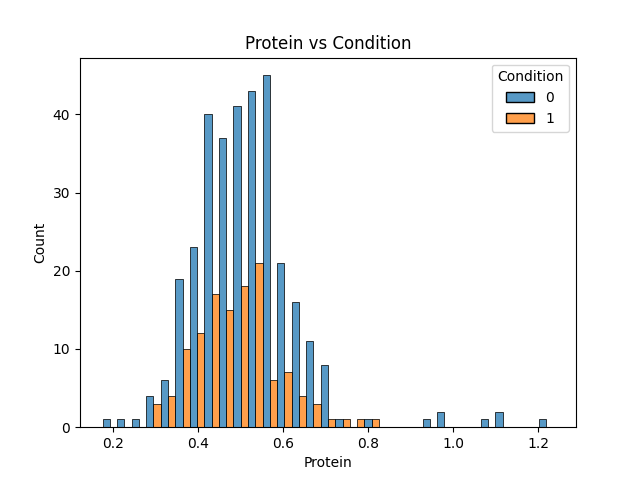

In [ ]:
plot_feature_vs_target(df, "Protein", "Condition")

It doesn't seem like the high values are an indicator of the condition. I will consider them as potential outliers. Let's count them. I choose my threshold based on where the normal distribution is cut off visually.

In [ ]:
df[df["Protein"] > 0.85]

,Patient_ID,Protein,pH,Specific_Gravity,Blood,Age,Gender,Glucose,Calcium,Condition
81,82,1.071423,5.792356,1.018254,0,75,1,133.730526,9.731333,0
168,169,0.950922,4.674515,1.022974,0,49,0,183.473858,10.196273,0
207,208,1.102757,6.877397,1.016685,0,57,1,171.673012,9.367143,0
371,372,1.099600,5.600851,1.028559,0,40,1,175.050611,8.023462,0
418,419,1.235859,5.776783,1.027642,0,28,1,159.869900,10.264683,0
443,444,0.982176,5.950412,1.013516,0,40,1,142.845685,9.771804,0
464,465,0.977534,5.955132,1.017097,0,29,0,162.224175,8.933859,0


In accordance with the histogram, there are 7 such cases. For all, Condition is 0 (healthy), hence I consider it reasonable to disqualify these samples.

In [ ]:
df = drop_rows_greater_thresh(df, "Protein", 0.85)

I similarly analyze the other features, but in my opinion there aren't other outliers.

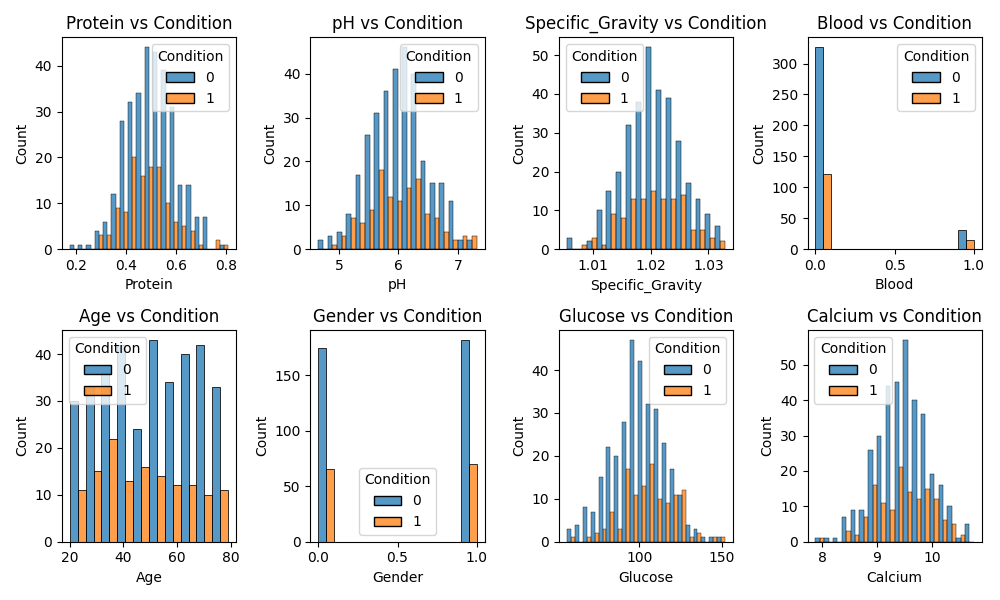

In [ ]:
_, ax = plt.subplots(nrows=2, ncols=4, figsize=(10,6))
ax = ax.flatten()
for i,feature in enumerate(FEATURE_COLS):
  plot_feature_vs_target(df, feature, "Condition", ax=ax[i])
plt.tight_layout();

Obvious observations:
1. Blood is almost never present
2. The condition is ditributed equally between genders
3. Glucose has the most visible separability, and that only skewness with big overlap
4. At around 30 years of age the condition seems to occur slightly more often than in other age groups, while not being largely more represented.
5. The rest do not show any obvious separation for the condition

In [ ]:
# Point (1)
df["Blood"].value_counts()

,count
Blood,
0,448
1,45


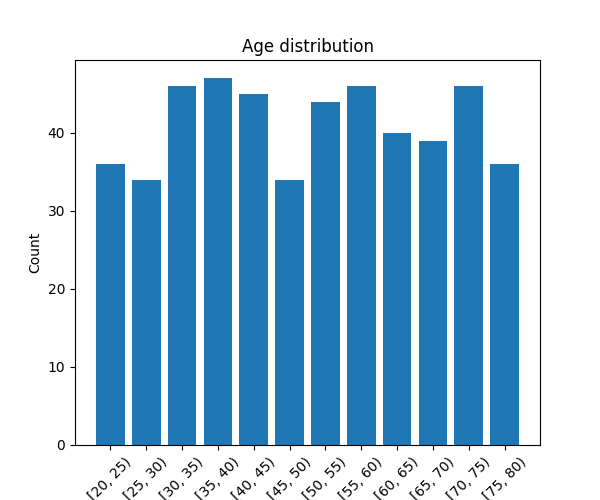

In [ ]:
# Age groups count for point (4)
age_bins = [20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]
age_df = pd.cut(df["Age"], age_bins, right=False).value_counts().sort_index()
plt.figure(figsize=(6,5))
plt.bar(x=np.arange(len(age_df)), height=age_df.values);
plt.xticks(ticks=np.arange(len(age_df)), labels=age_df.index.values, rotation=45);
plt.xlabel("Age group");
plt.ylabel("Count");
plt.title("Age distribution");

## Features exploration

In [ ]:
# plotted for self-understanding
# plotting takes a lot of time and resources, hence commented out for regular runs
# sns.pairplot(data=df, vars=FEATURE_COLS, hue=TARGET_COL[0], diag_kind="hist", height=1)

From the pairplot it doesn't seem like that any raw features present easily noticeable separability. Perhaps we must explore kernels or feature extraction.

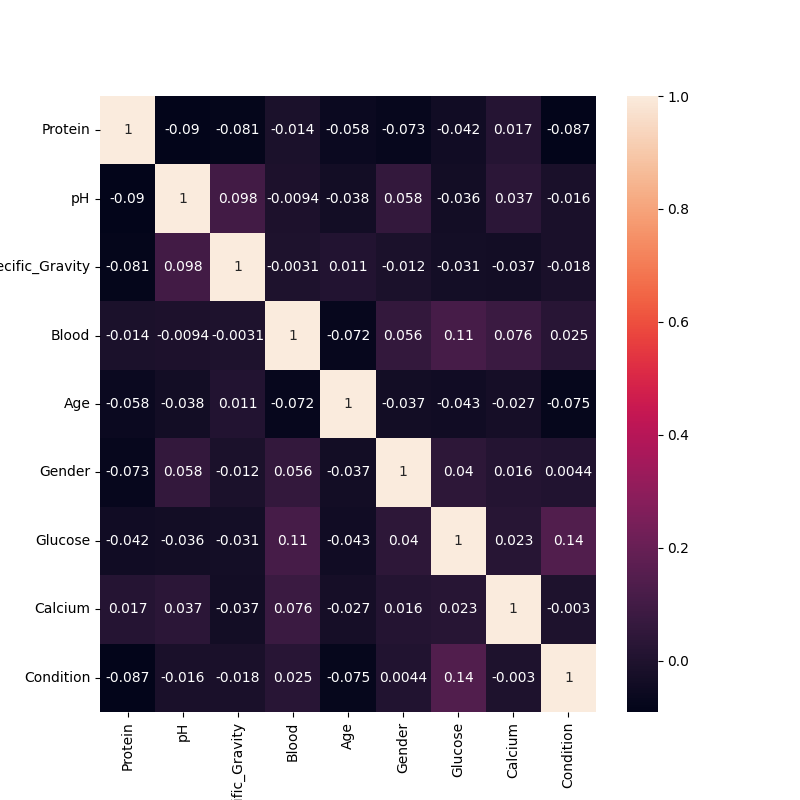

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(8,8))
ax = sns.heatmap(df.drop(["Patient_ID"], axis=1).corr(), annot=True)

No strong correations can be found.
Condition correlates the most with Glucose, so I will focus on filling those values (so as to not drop them).
Glucose somewhat correlates with Blood and pH with Specific_Gravity.

Blood is absent in most cases, but I wonder what its interaction with Glucose and Condition together due to their correlations.

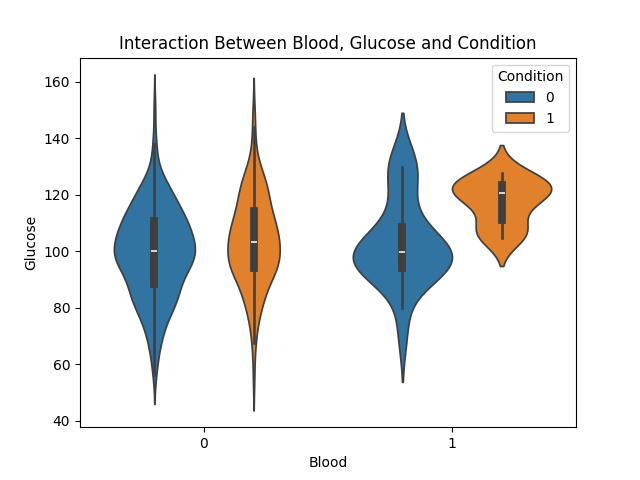

In [ ]:
plot_violin(df, "Blood", "Glucose", "Condition")

It seems that normally glucose is not very indicative of the condition. However, with blood present glucose levels show a good separation for the absense and presence of the condition. I wouldn't be surprised to see this play a role model's decisions.
The group sizes can be misleading due to rarety of blood, but I attempt to mitigate it by using a violin plot which estimates the kernel density.

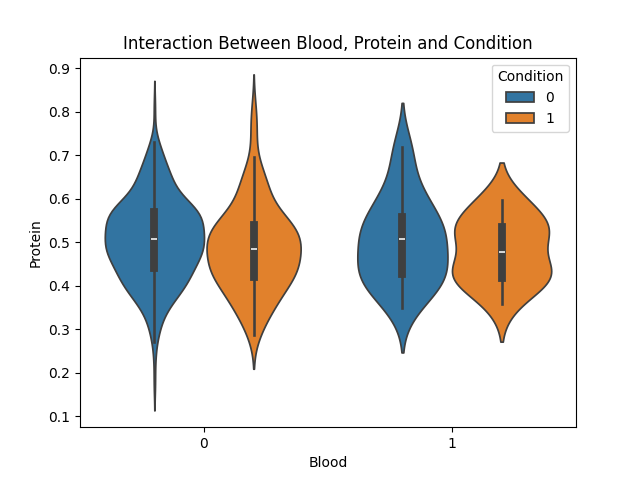

In [ ]:
plot_violin(df, 'Blood', 'Protein', 'Condition')

Protein on the other hand doesn't seem to have an effect on separation when co-occuring with Blood presense.

## Missing values

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 493 entries, 0 to 492
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Patient_ID        493 non-null    int64  
 1   Protein           443 non-null    float64
 2   pH                443 non-null    float64
 3   Specific_Gravity  443 non-null    float64
 4   Blood             493 non-null    int64  
 5   Age               493 non-null    int64  
 6   Gender            493 non-null    int64  
 7   Glucose           443 non-null    float64
 8   Calcium           493 non-null    float64
 9   Condition         493 non-null    int64  
dtypes: float64(5), int64(5)
memory usage: 38.6 KB


**Let**'s see if we can simply drop the missing values.

In [ ]:
df.dropna()

,Patient_ID,Protein,pH,Specific_Gravity,Blood,Age,Gender,Glucose,Calcium,Condition
0,1,0.549671,6.463089,1.026997,0,64,1,81.913568,9.099271,1
1,2,0.486174,6.954708,1.024623,0,51,0,97.284908,9.665405,1
2,3,0.564769,5.300716,1.020298,0,67,0,95.883400,9.347795,0
4,5,0.476585,5.674679,1.023491,0,23,0,96.926143,9.143055,0
5,6,0.476586,5.756437,1.021967,0,24,1,98.981833,10.345089,0
...,...,...,...,...,...,...,...,...,...,...
487,495,0.652312,5.499190,1.027711,0,20,1,100.248241,8.596706,0
488,496,0.553891,5.859450,1.030030,0,39,1,94.719166,9.597755,0
489,497,0.396275,6.898843,1.030308,1,74,1,131.587522,8.971471,0
490,498,0.480966,6.320421,1.026042,0,47,0,94.103182,9.019602,1


We can see that this results in a significant reduction of the data and is thus deemed undesirable.

In [ ]:
MISSING_FEATURE_COLS = ["Protein", "pH", "Specific_Gravity", "Glucose"]

We can see there are 50 missing values in a lot of categories: "Protein, pH, Specific_Gravity and Glucose".
I wonder how often those missing values miss together.

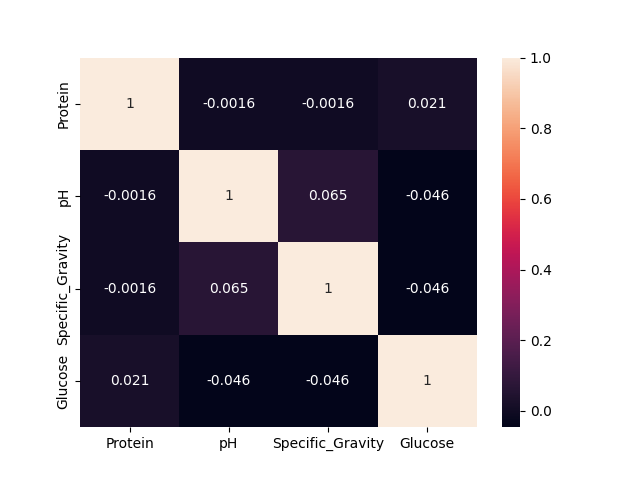

In [ ]:
plt.figure()
sns.heatmap(df[MISSING_FEATURE_COLS].isnull().corr(), annot=True)
plt.show()

Seems like there isn't a strong correlation between the missing values themselves. pH level, Specific_Gravity and Glucose have a triplet of the higher correlations, but such overlaps are still rare. It might be that the same factor affects ability to determine the pH level as Glucose.

I will attempt to graphically analyze if features show different values for when a certain feature is missing.

In [ ]:
# for the following visuals I will benefit if I normalize the data.

scaler = StandardScaler()
df_norm = df.copy()
numerical_features = ["Protein", "pH", "Specific_Gravity", "Age", "Glucose", "Calcium"]
df_norm[numerical_features] = scaler.fit_transform(df_norm[numerical_features])
df_norm = pd.DataFrame(df_norm, columns=df.columns)

In [ ]:
df_norm.head()

,Patient_ID,Protein,pH,Specific_Gravity,Blood,Age,Gender,Glucose,Calcium,Condition
0,1,0.506621,0.924796,1.276323,0,0.845480,1,-1.202607,-0.798204,1
1,2,-0.143960,1.941076,0.798933,0,0.079697,0,-0.246499,0.378634,1
2,3,0.661305,-1.478070,-0.070931,0,1.022199,0,-0.333674,-0.281590,0
3,4,NaN,0.549383,-0.781470,0,-0.509367,0,NaN,0.286491,0
4,5,-0.242206,-0.705011,0.571250,0,-1.569681,0,-0.268815,-0.707189,0


In [ ]:
analysis_dict = analyze_missing_data(df_norm, MISSING_FEATURE_COLS, FEATURE_COLS)

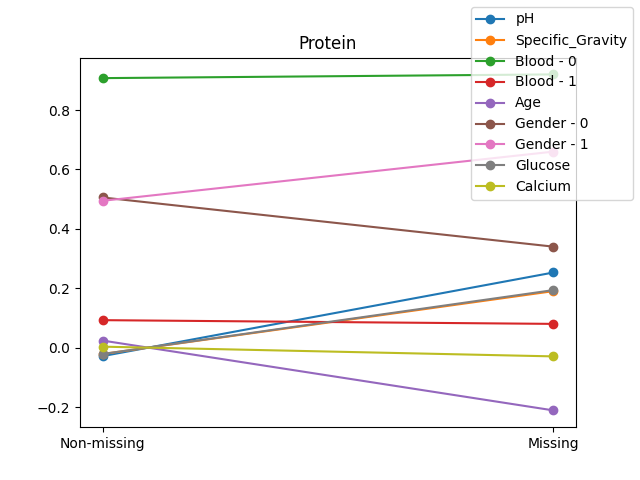

In [ ]:
plot_comparison(analysis_dict["Protein"], "Protein")

Upon visual inspection it seems like some features present differently in samples with missing values. Potentially, this could be used to impute the missing values using KNN Impution, which will be tested later in the notebook.

Still important to remember the differnce of the sample sizes. For each comparison, there are around 440 samples where the values are not missing, and 50 where they are.

# Model training

The dataset presents a plethora of problems:
1. Small size
2. Imbalance (natural to medical data)
3. Missing values
4. Bad separability (at least apparent separability)

I will test two imputing and two model strategies.

Imputing:
1. Simple Imputing - inserting average in place of continous missing values and most frequent in place of categorical missing values.
2. KNN Imputing  - finding the most similar samples based on present features and replacing a value with their average. For categorical data I will round this value. This method should work if my assumption about the missing values is correct, and patients with similar urine characteristic should somewhat share the other characteristic, as well as based on my examination of the features earlier.

Models:
1. Random Forest - this is a natural choice for when categorical data is present and we need to classify.
1. SVM - due to my inability to see any clear separation within the raw data, I hope that kernels might capture some patterns in the higher dimension.

I very much wanted to hack the case and not deal with missing values by employing XGBoost or LGBoost, but despite my attempts they are simply to difficult to tune on such a small dataset (in my opinion).

## Classes and functions block

In [ ]:
# Stand alone functions that do not depend on the model
def report(y_true, y_pred):
    """
    Prints the classification report.
    """
    assert len(y_true)==len(y_pred)
    print(classification_report(y_true, y_pred))

def conf_matrix(y_true, y_pred, plot=False):
  """
  Prints or plots(plot=True) the confusion matrix
  """
  assert len(y_true)==len(y_pred)
  if not plot:
    print("Confusion Matrix")
    print(confusion_matrix(y_true, y_pred))
  else:
    plt.figure()
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.show()

def plot_roc_curve(y_true, y_proba):
  """
  Plots the ROC curve.
  """
  try:
    fpr, tpr, thresholds = roc_curve(y_true, y_proba)
  except ValueError as e:
    raise ValueError(f"Error computing ROC {str(e)}")
  try:
    roc_auc = roc_auc_score(y_true, y_proba)
  except ValueError as e:
    raise ValueError(f"Error computing AUC {str(e)}")

  # I switch to plotly to allow interactive observation of AUC score
  # adjusted from plotly example
  fig = px.area(
      x=fpr, y=tpr,
      title=f'ROC (AUC={roc_auc:.4f})',
      labels=dict(x='FP Rate', y='TP Rate'),
      width=700, height=500,
      hover_data={'x': fpr, 'y': tpr, 'thresh': thresholds}
  )
  fig.add_shape(
      type='line', line=dict(dash='dash'),
      x0=0, x1=1, y0=0, y1=1
  )

  fig.update_yaxes(scaleanchor="x", scaleratio=1)
  fig.update_xaxes(constrain='domain')
  fig.show()

In [ ]:
def ensure_fitted(method):
    """
    Decorator to check if the model is fitted before executing a method.
    """
    @wraps(method)
    def wrapper(self, *args, **kwargs):
        try:
            check_is_fitted(self.model)
        except NotFittedError:
            raise NotFittedError()
        return method(self, *args, **kwargs)

    return wrapper

class BaseModel():

  def __init__(self, model):
    assert isinstance(model, BaseEstimator)
    self.model = model
    self.init_params = self.model.get_params()

  def fit(self, X, y):
    """
    Fits the model.
    """
    if len(X)!=len(y):
      raise ValueError("X and y must have the same length")
    self.model.fit(X, y)

  @ensure_fitted
  def predict(self, X):
    """
    Predicts the target variable.
    """
    return self.model.predict(X)

  def cross_validate(self, param_grid, X, y, X_test=None, y_test=None,
                     scoring='roc_auc', n_splits=5, random_state=42, verbose=0):
    """
    Performs cross validation on the model.
    Automatically chooses StratifiedKFold.
    """
    if ('early_stopping_rounds' in param_grid.keys()) and (X_test is None or y_test is None):
      raise ValueError("X_test and y_test must be provided if early_stopping_rounds is given")

    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    model = self.create_model()
    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring=scoring, verbose=verbose)

    # execute the grid search
    if 'early_stopping_rounds' in param_grid.keys():
      grid_result = grid.fit(X, y, eval_set=[(X_test, y_test)])
    else:
      grid_result = grid.fit(X, y)
    # report the best configuration
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    return grid_result, grid

  def create_model(self):
    """
    Create a new model instance with the initial parameters.
    To ensure initial parameters not part of the grid are not overwritten.
    """
    raise NotImplementedError("This method should be implemented in subclasses")


class RF(BaseModel):

  def __init__(self, **params):
    model = RandomForestClassifier(**params)
    super().__init__(model)

  def create_model(self):
    model = RandomForestClassifier(**self.init_params)
    return model

  @ensure_fitted
  def plot_feature_importance(self, feature_cols):
    sorted_idx = self.model.feature_importances_.argsort()
    fig = plt.figure()
    plt.barh(np.array(feature_cols)[sorted_idx], self.model.feature_importances_[sorted_idx])
    plt.xlabel("Random Forest Feature Importance");

  @ensure_fitted
  def predict(self, X, thresh=0.5):
    """
    Predicts the target variable
    with flexible threshold
    """
    pred = self.model.predict_proba(X)[:,1]
    return (pred > thresh).astype(int)

  @ensure_fitted
  def calc_proba(self, X):
    return self.model.predict_proba(X)[:,1]


class XGB(BaseModel):

  def __init__(self, **params):
    model = XGBClassifier(tree_method="hist", objective='binary:logistic', **params)
    super().__init__(model)

  def create_model(self):
    model = XGBClassifier(**self.init_params)
    return model

  @ensure_fitted
  def plot_feature_importance(self, feature_cols):
    sorted_idx = self.model.feature_importances_.argsort()
    plt.figure()
    plt.barh(np.array(feature_cols)[sorted_idx], self.model.feature_importances_[sorted_idx])
    plt.xlabel("Xgboost Feature Importance");

  @ensure_fitted
  def predict(self, X, thresh=0.5):
    """
    Predicts the target variable
    with flexible threshold
    """
    pred = self.model.predict_proba(X)[:,1]
    return (pred > thresh).astype(int)

  @ensure_fitted
  def calc_proba(self, X):
    return self.model.predict_proba(X)[:,1]


class LGBM(BaseModel):

  def __init__(self, **params):
    model = lgb.LGBMClassifier(objective="binary", seed=42,
                                    verbose=-1, **params)
    super().__init__(model)

  def create_model(self):
    model = lgb.LGBMClassifier(**self.init_params)
    return model

  @ensure_fitted
  def predict(self, X, thresh=0.5):
    """
    Predicts the target variable
    with flexible threshold
    """
    pred = self.model.predict_proba(X)[:,1]
    return (pred > thresh).astype(int)

  @ensure_fitted
  def calc_proba(self, X):
    return self.model.predict_proba(X)[:,1]


class SVM(BaseModel):

  def __init__(self, **params):
    model = svm.SVC(**params)
    super().__init__(model)

  def create_model(self):
    model = svm.SVC(**self.init_params)
    return model

  @ensure_fitted
  def calc_proba(self, X):
    return self.model.decision_function(X)

In [ ]:
  def calc_class_weights(y_train):
    """
    Calculates the class weights for the model.
    """
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = dict(enumerate(class_weights))
    return class_weight_dict

In [ ]:
class Dataset():
  """
  Assumes one target column
  """

  def __init__(self, df, feature_cols, target_col, numerical_columns):
    assert isinstance(df, pd.DataFrame)

    if not all([col in df.columns for col in feature_cols]):
      raise ValueError("Not all feature columns are in dataframe")
    if target_col not in df.columns:
      raise ValueError("Target column not in dataframe")
    if not max(numerical_columns)  < len(feature_cols):
      raise ValueError("Numerical columns index out of range")

    self.df = df
    self.feature_cols = feature_cols
    self.target_col = target_col
    self.numerical_columns = numerical_columns
    self.cat_columns = [col for col in range(len(feature_cols)) if col not in numerical_columns]
    self.scaler = None

  def split_data(self, test_size=0.2, random_state=42, normalize=True, impute='None', n_knn=1):
    """
    Splits the data.

    Parameters
    ----------
    test_size : float, default=0.2
        The proportion of the dataset to include in the test split.
    random_state : int, default=42
        The seed used by the random number generator.
    normalize : boolean, default=True
        Whether to normlize the data.
    impute : string, default='None'
        Whether to impute the data, method to impute ('simple', 'knn').
    """
    X, y = self.df[self.feature_cols].values, self.df[self.target_col].values
    # I stratify on the target
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,
                                                        random_state=random_state,
                                                        stratify=self.df[self.target_col])

    y_train = np.squeeze(y_train)
    y_test = np.squeeze(y_test)

    if normalize:
      X_train, X_test, self.scaler = self.normalize_numerical(X_train, X_test)

    if impute == 'simple':
      X_train, X_test = self.simple_impute(X_train, X_test)
    elif impute == 'knn':
      X_train, X_test = self.knn_impute(X_train, X_test, n_neighbors=n_knn)

    # print("Training size: ", X_train.shape)
    # print("Test/Validation size: ", X_test.shape)

    return X, y, X_train, X_test, y_train, y_test

  def normalize_numerical(self, X_train, X_test):
    # although it is said that LGBM and XGBoost do not require data normalzation
    # I found that it improves the LGBM performance
    # I decided to keep the normalization homogenous across the models
    # I only normalize the continous variables
    scaler = StandardScaler()
    X_train[:,self.numerical_columns] = scaler.fit_transform(X_train[:,self.numerical_columns])
    X_test[:,self.numerical_columns] = scaler.transform(X_test[:,self.numerical_columns])
    return X_train, X_test, scaler

  def simple_impute(self, X_train, X_test):
    """
    Imputes the data with mean and most frequent values.
    """
    X_train_imputed = X_train.copy()
    X_test_imputed = X_test.copy()

    imputer = SimpleImputer(missing_values=np.nan, strategy="mean")
    X_train_imputed[:,self.numerical_columns] = imputer.fit_transform(X_train_imputed[:,self.numerical_columns])
    X_test_imputed[:,self.numerical_columns] = imputer.transform(X_test_imputed[:,self.numerical_columns])

    imputer = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
    X_train_imputed[:,self.cat_columns] = imputer.fit_transform(X_train_imputed[:,self.cat_columns])
    X_test_imputed[:,self.cat_columns] = imputer.transform(X_test_imputed[:,self.cat_columns])

    return X_train_imputed, X_test_imputed

  def knn_impute(self, X_train, X_test, n_neighbors):
    """
    Imputes the data with KNN method.
    """
    X_train_imputed = X_train.copy()
    X_test_imputed = X_test.copy()

    imputer = KNNImputer(n_neighbors=n_neighbors)
    X_train_imputed[:,self.numerical_columns] = imputer.fit_transform(X_train_imputed[:,self.numerical_columns])
    X_test_imputed[:,self.numerical_columns] = imputer.transform(X_test_imputed[:,self.numerical_columns])

    # I round the result of the transformation
    # to get the approximation of a categorical value
    # I could alternatively use 1 neighbor
    imputer = KNNImputer(n_neighbors=n_neighbors)
    X_train_imputed[:,self.cat_columns] = np.round(imputer.fit_transform(X_train_imputed[:,self.cat_columns])).astype(int)
    X_test_imputed[:,self.cat_columns] = np.round(imputer.transform(X_test_imputed[:,self.cat_columns])).astype(int)

    return X_train_imputed, X_test_imputed

## Unit tests

In [ ]:
import unittest

In [ ]:
class TestDataset(unittest.TestCase):

  @classmethod
  def setUpClass(cls):
    cls.df = pd.DataFrame([[np.nan, 0.5, 1.5, 1],
                      [0, 1.5, 0.5, 0],
                      [1, 0.75, np.nan, 1],
                      [0, 1.25, 0.75, 0]], columns=['A', 'B', 'C', 'D'])
    cls.feature_cols = ['A', 'B', 'C']
    cls.target_col = 'D'
    cls.numerical_columns = [1, 2]

  def setUp(self):
    self.dataset = Dataset(self.df, self.feature_cols, self.target_col, self.numerical_columns)

  def test_init1(self):
    self.assertRaises(Exception, Dataset, self.df, ['F'], self.target_col, self.numerical_columns)
  def test_init2(self):
    self.assertRaises(Exception, Dataset, self.df, self.feature_cols, 'F', self.numerical_columns)
  def test_init3(self):
    self.assertRaises(Exception, Dataset, self.df, self.feature_cols, self.target_col, [5])

  def test_split_data(self):
    _, _, X_train, X_test, y_train, y_test = self.dataset.split_data(test_size=0.5)
    self.assertEqual(X_train.shape, (2, 3))
    self.assertEqual(X_test.shape, (2, 3))
    self.assertEqual(y_train.shape, (2,))
    self.assertEqual(y_test.shape, (2,))

  def test_simple_impute(self):
    _, _, X_train, X_test, _, _ = self.dataset.split_data(test_size=0.5)

    X_train_imp, X_test_imp = self.dataset.simple_impute(X_train, X_test)

    # Check if NaN values were imputed
    self.assertFalse(np.isnan(X_train_imp).any())
    self.assertFalse(np.isnan(X_test_imp).any())

  def test_knn_impute(self):
    _, _, X_train, X_test, _, _ = self.dataset.split_data(test_size=0.5)

    X_train_imp, X_test_imp = self.dataset.knn_impute(X_train, X_test)

    # Check if NaN values were imputed
    self.assertFalse(np.isnan(X_train_imp).any())
    self.assertFalse(np.isnan(X_test_imp).any())

In [ ]:
class TestModels(unittest.TestCase):

  @classmethod
  def setUpClass(cls):
    X, y = make_classification(random_state=42)
    cls.X_train, cls.X_test, cls.y_train, cls.y_test = train_test_split(X, y, random_state=42)

  def test_RF_init(self):
    clf = RF(random_state=42)
    self.assertRaises(Exception, clf.fit, self.X_train, self.y_train[:50])

  def test_RF_fit_predict(self):
    clf = RF(random_state=42)
    clf.fit(self.X_train, self.y_train)
    preds = clf.predict(self.X_test)
    self.assertEqual(preds.shape, self.y_test.shape)
    self.assertGreaterEqual(accuracy_score(self.y_test, preds), 0.5)

  def test_RF_unfit(self):
    clf = RF(random_state=42)
    self.assertRaises(Exception, clf.predict, X_test)
    self.assertRaises(Exception, clf.plot_feature_importance, ['A', 'B', 'C'])

  def test_cross_validation(self):
    clf = RF(random_state=42)
    param_grid = {'n_estimators': [2,3]}
    grid_result, grid = clf.cross_validate(param_grid, self.X_train, self.y_train)
    self.assertIsNotNone(grid_result.best_params_)

  def test_SVM_init(self):
    clf = SVM(random_state=42)
    self.assertRaises(Exception, clf.fit, self.X_train, self.y_train[:50])

  def test_SVM_fit_predict(self):
    clf = SVM(random_state=42)
    clf.fit(self.X_train, self.y_train)
    preds = clf.predict(self.X_test)
    self.assertEqual(preds.shape, self.y_test.shape)
    self.assertGreaterEqual(accuracy_score(self.y_test, preds), 0.5)

  def test_XGB_init(self):
    clf = XGB(random_state=42)
    self.assertRaises(Exception, clf.fit, self.X_train, self.y_train[:50])

  def test_XGB_fit_predict(self):
    clf = XGB(random_state=42)
    clf.fit(self.X_train, self.y_train)
    preds = clf.predict(self.X_test)
    self.assertEqual(preds.shape, self.y_test.shape)
    self.assertGreaterEqual(accuracy_score(self.y_test, preds), 0.5)

  def test_LGB_init(self):
    clf = LGBM(random_state=42)
    self.assertRaises(Exception, clf.fit, self.X_train, self.y_train[:50])

  def test_LGB_fit_predict(self):
    clf = LGBM(random_state=42)
    clf.fit(self.X_train, self.y_train)
    preds = clf.predict(self.X_test)
    self.assertEqual(preds.shape, self.y_test.shape)
    self.assertGreaterEqual(accuracy_score(self.y_test, preds), 0.5)


In [ ]:
unittest.main(argv=[''], verbosity=2, exit=False)

test_init1 (__main__.TestDataset) ... ok
test_init2 (__main__.TestDataset) ... ok
test_init3 (__main__.TestDataset) ... ok
test_knn_impute (__main__.TestDataset) ... ok
test_simple_impute (__main__.TestDataset) ... ok
test_split_data (__main__.TestDataset) ... ok
test_LGB_fit_predict (__main__.TestModels) ... ok
test_LGB_init (__main__.TestModels) ... ok
test_RF_fit_predict (__main__.TestModels) ... ok
test_RF_init (__main__.TestModels) ... ok
test_RF_unfit (__main__.TestModels) ... ok
test_SVM_fit_predict (__main__.TestModels) ... ok
test_SVM_init (__main__.TestModels) ... ok
test_XGB_fit_predict (__main__.TestModels) ... ok
test_XGB_init (__main__.TestModels) ... ok
test_cross_validation (__main__.TestModels) ... ok

----------------------------------------------------------------------
Ran 16 tests in 3.182s

OK


Best: 0.912500 using {'n_estimators': 3}


# Random Forest

## Simple Impute

In [ ]:
dataset = Dataset(df, FEATURE_COLS, TARGET_COL[0], NUMERICAL_COLS)

In [ ]:
X, y, X_train, X_test, y_train, y_test = dataset.split_data(impute='simple')

In [ ]:
class_weight_dict = calc_class_weights(y_train)

I will use class weights to try and combat the imbalance.

In [ ]:
# base model
clf = RF(class_weight=class_weight_dict, max_depth=4, random_state=42)
clf.fit(X_train, y_train)

In [ ]:
preds = clf.predict(X_test)
y_proba = clf.calc_proba(X_test)

In [ ]:
report(y_test, preds)

              precision    recall  f1-score   support

           0       0.80      0.85      0.82        72
           1       0.52      0.44      0.48        27

    accuracy                           0.74        99
   macro avg       0.66      0.65      0.65        99
weighted avg       0.73      0.74      0.73        99



The accuracy is 0.74, the recall for Condition is below 50%, but it isn't a bad start for such dataset.

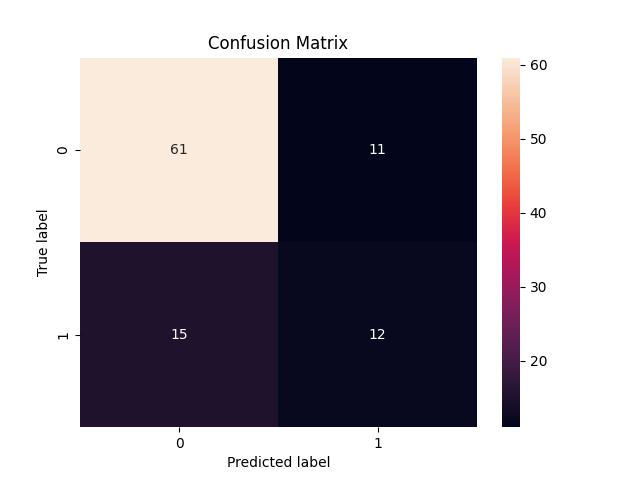

In [ ]:
conf_matrix(y_test, preds, plot=True)

In [ ]:
plot_roc_curve(y_test, y_proba)

The model's ability to distinguish between classes is quite high (compared to what I have seen for this data). This is likely due to the high number of non-condition classified correctly.

## KNN Impute

I will repeat the experiment to see which data preprocessing to choose and then I will cross-validate and grid search the model.

In [ ]:
dataset = Dataset(df, FEATURE_COLS, TARGET_COL[0], NUMERICAL_COLS)

In [ ]:
X, y, X_train, X_test, y_train, y_test = dataset.split_data(impute='knn', n_knn=20)

In [ ]:
class_weight_dict = calc_class_weights(y_train)

In [ ]:
# base model
clf = RF(class_weight=class_weight_dict, max_depth=4, random_state=42, )
clf.fit(X_train, y_train)

In [ ]:
preds = clf.predict(X_test)
y_proba = clf.calc_proba(X_test)

In [ ]:
report(y_test, preds)

              precision    recall  f1-score   support

           0       0.81      0.82      0.81        72
           1       0.50      0.48      0.49        27

    accuracy                           0.73        99
   macro avg       0.65      0.65      0.65        99
weighted avg       0.72      0.73      0.73        99



The accuracy slightly decreased, but the recall has slightly improved improved. I might prefer KNN in that case.

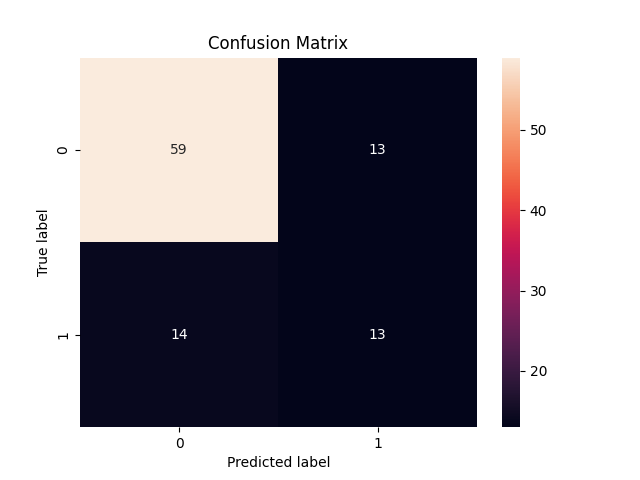

In [ ]:
conf_matrix(y_test, preds, plot=True)

In [ ]:
plot_roc_curve(y_test, y_proba)

The AUC has also improved, which makes me want to continue with KNN Imputing further.

## Cross Validation

There are two things to consider:
1. Number of neighbors I use for Imputy
2. Model parameters.

I will first try different imputy on the base model, and then use this value for cross-validation. Although arguably due to the size of the dataset it is not very reliable, but I want some argument for the number of the neighbors.

In [ ]:
dataset = Dataset(df, FEATURE_COLS, TARGET_COL[0], NUMERICAL_COLS)

In [ ]:
n_neighbors = np.arange(1, 50, 10)
res = {}
for n in n_neighbors:
  X, y, X_train, X_test, y_train, y_test = dataset.split_data(impute='knn', n_knn=n)
  clf = RF(class_weight=class_weight_dict, max_depth=4, random_state=42)
  clf.fit(X_train, y_train)
  preds = clf.predict(X_test)
  res[n] = (accuracy_score(y_test, preds), recall_score(y_test, preds))

In [ ]:
print("n_neighbors, accuracy, recall")
for key, value in res.items():
  print(key, value)

n_neighbors, accuracy, recall
1 (0.7373737373737373, 0.4444444444444444)
11 (0.7171717171717171, 0.4074074074074074)
21 (0.7171717171717171, 0.4444444444444444)
31 (0.7575757575757576, 0.4444444444444444)
41 (0.7171717171717171, 0.37037037037037035)


It seems that the best recall is the best n=30. Let's continue with that. It might be that the dataset is so small, that the nearest neighbors are too specific.

In [ ]:
N_NEIGHBORS = 30

GridSearch and CrossValidation

In [ ]:
X, y, X_train, X_test, y_train, y_test = dataset.split_data(impute='knn', n_knn=N_NEIGHBORS)
clf = RF(class_weight=class_weight_dict, random_state=42)

I will try two runs:
1. Default scoring
2. F1 scoring, which balances recall and precision

In [ ]:
param_grid = {'n_estimators': [200, 300, 400],
              'min_samples_leaf': [1, 5, 10],
              'max_depth': [2, 4, 6],
              'criterion': ["gini", "entropy", "log_loss"]}

start_time = time.time()
grid_result, grid = clf.cross_validate(param_grid, X_train, y_train,
                                       n_splits=5, verbose=1, scoring='f1')
print("Grid search took: ", time.time() - start_time)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best: 0.295271 using {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 10, 'n_estimators': 300}
Grid search took:  214.3952124118805


## Results analysis

**Best with default scoring**

*Parameters:*
Best: 0.492952 using {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 1, 'n_estimators': 400}

*Metrics:*
Accuracy - 0.66, recall - 0.56, f1 - 0.47, AUC - 0.66

**Best with f1 scoring:**

*Parameters:*
Best: 0.295271 using {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 10, 'n_estimators': 300}

*Metrics:*
Accuracy - 0.67, recall - 0.56, f1 - 0.48, AUC - 0.67


While during my experiments I have reach AUC of 0.71, the recall is the best I have achieved, and I considered it the more important metric.

In [ ]:
clf = RF(class_weight=class_weight_dict, random_state=42, criterion='gini',
         max_depth=2, min_samples_leaf=10, n_estimators=300)
clf.fit(X_train, y_train)

In [ ]:
preds = clf.predict(X_test)
y_proba = clf.calc_proba(X_test)

In [ ]:
report(y_test, preds)

              precision    recall  f1-score   support

           0       0.81      0.71      0.76        72
           1       0.42      0.56      0.48        27

    accuracy                           0.67        99
   macro avg       0.61      0.63      0.62        99
weighted avg       0.70      0.67      0.68        99



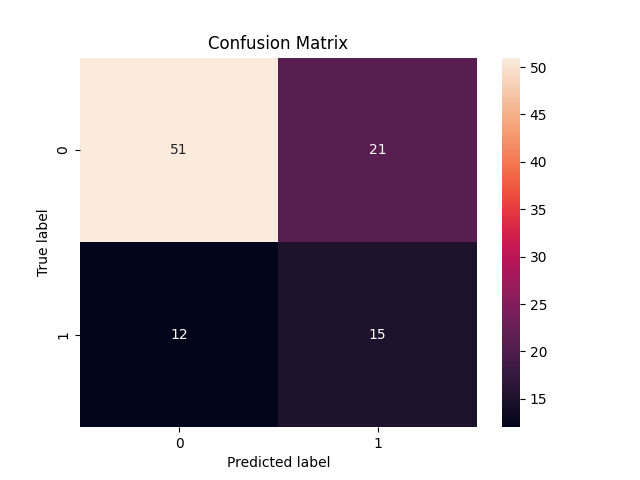

In [ ]:
conf_matrix(y_test, preds, plot=True)

In [ ]:
plot_roc_curve(y_test, y_proba)

# Summary and error analysis

1. Limitations - as for any model in this case, the data is the big limitation. Its size which makes it difficult to train and evaluate, its many missing values which require approximations, and its non-apparent separability. For random forest to perform well, training needs to be a good representation of the actual population, as well as features to be meaningful. With such small dataset and the split, I'm not sure RF trains to generalize well enough (I will check training vs test accuracy), and with the poor apparent separability, the splits might be close to arbitrary.
2. Potential improvements - I could use a technique for oversampling in place/together with the weights. For example, simple undersampling of the majority class and/or oversampling the minority, or a more complex SMOTE that simulates new cases based on the existing data. I would be reluctant regarding SMOTE as it creates more approximations, which I don't think are desirable in the medical data. Another improvement could be better data preparation and feature engineering, possibly feature selection. I also could run a broader GridSearch to find more optimal parameters.
3. Implications of my findings are:
  * It is a difficult condition to classify given the current raw features. We could benefit from obtaining more data, both number of patients and perhaps some other tests.
  * Random Forest performs better than random and does learn the condition as well as healthy, reaching almost 0.6 recall on condition, meaning it catches ~0.6 of the actual cases. However, there is a high rate of false positives as well, as is shown by relatively low precision, meaning that it does not distinguish between healthy and sick as much as would be desired, flagging many healthy people as sick.

Is the model overfitting?

In [ ]:
print("Results on the training data")
print(report(y_train, clf.predict(X_train)))

print("Results on the test data")
print(report(y_test, preds))

Results on the training data
              precision    recall  f1-score   support

           0       0.81      0.78      0.80       285
           1       0.47      0.51      0.49       109

    accuracy                           0.71       394
   macro avg       0.64      0.65      0.64       394
weighted avg       0.72      0.71      0.71       394

None
Results on the test data
              precision    recall  f1-score   support

           0       0.81      0.71      0.76        72
           1       0.42      0.56      0.48        27

    accuracy                           0.67        99
   macro avg       0.61      0.63      0.62        99
weighted avg       0.70      0.67      0.68        99

None


It slightly overfits, and I suspect in metrics where it doesn't, such as recall, it's a question of the sample size and the split. Ideally, one should collect the scores from a cross-validation.

Firstly, I want to look at the distribution of the probabilities. Every prediction is a probability cut at a threshold. By default such threshold is 0.5, but what does it mean if my model outputs probabilities in the range 0.4-0.6?

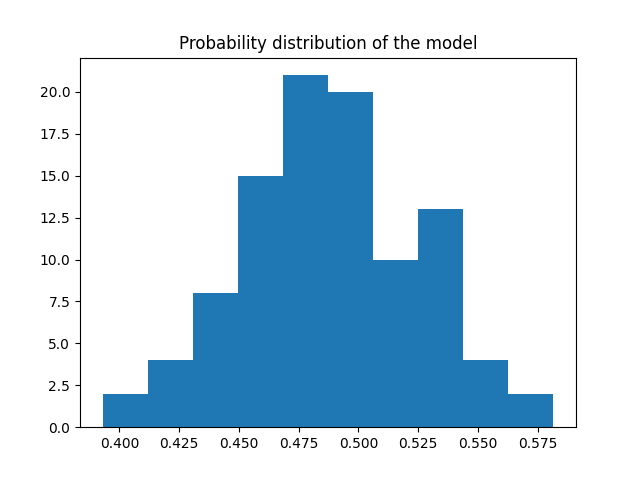

In [ ]:
plt.figure()
plt.hist(y_proba)
plt.title("Probability distribution of the model");

It might be that I have over-regularized my parameter search in attempt to not overfit - the probability range is quite narrow which could indicate that the samples are too stacked together in the leaves losing specificity.

In [ ]:
# we use the same default random seed
_,_, _, X_test_unimputed, _, _ = dataset.split_data(impute='None', n_knn=N_NEIGHBORS)

In [ ]:
# sanity check that entries coinside
assert X_test.shape==X_test_unimputed.shape
assert np.allclose(X_test[0], X_test_unimputed[0])

In [ ]:
missclassified = X_test_unimputed[y_test != preds]
missclassified_df = pd.DataFrame(missclassified, columns=FEATURE_COLS)
missclassified_df[TARGET_COL] = y_test[y_test != preds].reshape(-1,1)
missclassified_df["Prediction"] = preds[y_test != preds].reshape(-1,1)
missclassified_df.head()

,Protein,pH,Specific_Gravity,Blood,Age,Gender,Glucose,Calcium,Condition,Prediction
0,-0.624802,1.566105,-1.594898,0.0,-0.097797,1.0,-0.941016,1.219434,0,1
1,0.228747,-1.548836,-0.052213,0.0,0.964340,0.0,1.336982,-0.689619,0,1
2,0.534591,0.515521,-1.746910,0.0,-0.333827,0.0,1.317797,0.440850,0,1
3,0.883145,-2.282355,-0.671042,0.0,1.377393,0.0,1.239992,-1.123591,0,1
4,-0.070757,0.363584,0.575041,0.0,1.082355,0.0,-0.386304,-1.153439,1,0


In [ ]:
missclassified_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Protein           30 non-null     float64
 1   pH                30 non-null     float64
 2   Specific_Gravity  30 non-null     float64
 3   Blood             33 non-null     float64
 4   Age               33 non-null     float64
 5   Gender            33 non-null     float64
 6   Glucose           31 non-null     float64
 7   Calcium           33 non-null     float64
 8   Condition         33 non-null     int64  
 9   Prediction        33 non-null     int64  
dtypes: float64(8), int64(2)
memory usage: 2.7 KB


In [ ]:
# Reminder
conf_matrix(missclassified_df[TARGET_COL], missclassified_df["Prediction"], plot=False)

Confusion Matrix
[[ 0 21]
 [12  0]]


There are seemingly more healthy people misclassified, however this is not normalized to the total number of samples in each group. In actuality, 21/72 and 12/27.

There are 33/99 (1/3 of the whole test set) misclassified samples. Out of those 33, there are around 3 missing values per the appropriate column. I wonder how many misclassification happened to the samples with a missing value.

In [ ]:
missclassified_df[missclassified_df.isnull().any(axis=1)].groupby("Condition")["Prediction"].value_counts()

,,count
Condition,Prediction,
0,1,6
1,0,4


In [ ]:
df[df.isnull().any(axis=1)].shape

(173, 10)

Exactly 10 samples, which constitues roughly 10% of the whole test set. It's around equally conditoin and non-condition. It's difficult to draw any conclusions on such a small test set, but I think 10% compared to the general prevalence of the samples with missing values (173/500) is not a lot. Yet, maybe a different strategy for missing values should have been employed.

Let's look at the features that might contribute to the misclassification, in comparison to the correctly classified.

In [ ]:
correctly_classified_df = X_test_unimputed[y_test == preds]
correctly_classified_df = pd.DataFrame(correctly_classified_df, columns=FEATURE_COLS)
correctly_classified_df[TARGET_COL] = y_test[y_test == preds].reshape(-1,1)
correctly_classified_df["Prediction"] = preds[y_test == preds].reshape(-1,1)

Text(0.5, 1.0, 'Correctly classified samples')

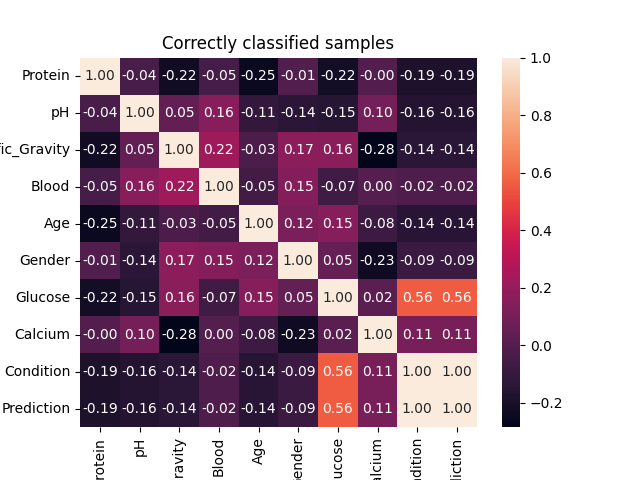

In [ ]:
plt.figure()
sns.heatmap(correctly_classified_df.corr(), annot=True, fmt='.2f')
plt.title("Correctly classified samples")

Glucose seems to be significantly more correlated with the condition than any other feature.

Text(0.5, 1.0, 'Misclassified samples')

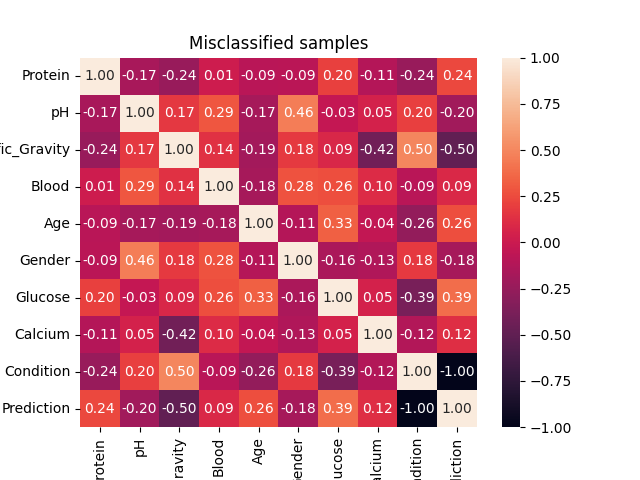

In [ ]:
plt.figure()
sns.heatmap(missclassified_df.corr(), annot=True, fmt='.2f')
plt.title("Misclassified samples")

Interetingly, for misclassified cases, Specific_Gravity seems to be more important, or misleading, than Glucose.

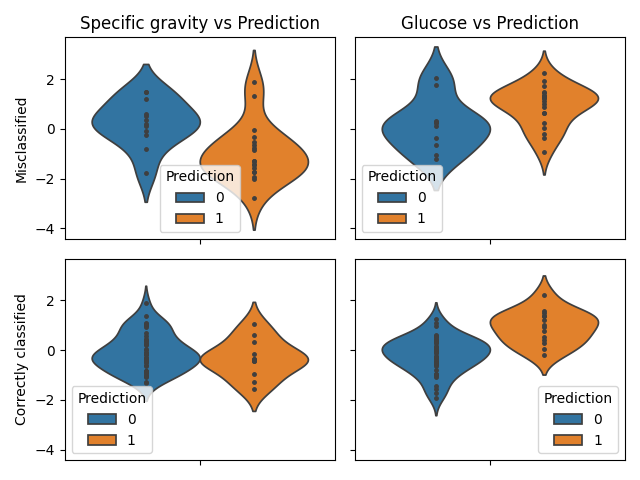

In [ ]:
fig,ax=plt.subplots(nrows=2, ncols=2, sharey=True)
sns.violinplot(data=missclassified_df, y='Specific_Gravity', hue='Prediction',
               ax=ax[0,0], inner="point", density_norm="count")
sns.violinplot(data=correctly_classified_df,
               y='Specific_Gravity', hue='Prediction',
               ax=ax[1,0], inner="point", density_norm="count")
sns.violinplot(data=missclassified_df, y='Glucose', hue='Prediction',
               ax=ax[0,1], inner="point", density_norm="count")
sns.violinplot(data=correctly_classified_df, y='Glucose', hue='Prediction',
               ax=ax[1,1], inner="point", density_norm="count")
ax[0,0].set_title(f'Specific gravity vs Prediction')
ax[0,1].set_title(f'Glucose vs Prediction')
ax[0,0].set_ylabel("Misclassified")
ax[1,0].set_ylabel("Correctly classified")
plt.tight_layout()

For correctly classified cases, there is no visual separation based on the Specific gravity, as there is for glucose for example. But for misclassified cases, there seems to be a separation such that healthy patients with lower Specific gravity are more likely to be classified as sick.

Let's look at some groups. For this I will concatenate both correctly and incorrectly classified dataframes, inversely transform the values for better intuitive understanding, and look at some group individually.

In [ ]:
concat_df = pd.concat([correctly_classified_df, missclassified_df])
concat_df.iloc[:,NUMERICAL_COLS] = dataset.scaler.inverse_transform(concat_df.iloc[:,NUMERICAL_COLS])
concat_df["Miss"] = np.zeros(len(concat_df))
concat_df["Miss"][:len(correctly_classified_df)] = 0
concat_df["Miss"][len(correctly_classified_df):] = 1

<ipython-input-345-8f1074bf4dac>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-345-8f1074bf4dac>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
concat_df.describe()

,Protein,pH,Specific_Gravity,Blood,Age,Gender,Glucose,Calcium,Condition,Prediction,Miss
count,89.000000,88.000000,87.000000,99.000000,99.000000,99.000000,89.000000,99.000000,99.000000,99.000000,99.000000
mean,0.516281,6.095708,1.019676,0.090909,49.606061,0.575758,104.875247,9.506968,0.272727,0.363636,0.333333
std,0.097366,0.482841,0.004742,0.288943,17.178426,0.496743,14.956921,0.487930,0.447628,0.483494,0.473804
min,0.356986,4.894432,1.007045,0.000000,20.000000,0.000000,68.893807,8.331123,0.000000,0.000000,0.000000
25%,0.433821,5.728190,1.016651,0.000000,36.000000,0.000000,94.937076,9.199552,0.000000,0.000000,0.000000
50%,0.507580,6.154176,1.019238,0.000000,50.000000,1.000000,104.623913,9.527340,0.000000,0.000000,0.000000
75%,0.575897,6.392866,1.022699,0.000000,65.000000,1.000000,116.651764,9.864352,1.000000,1.000000,1.000000
max,0.808892,7.286680,1.030308,1.000000,79.000000,1.000000,136.808550,10.764782,1.000000,1.000000,1.000000


The statistics look reasonable when compared to the original data.

In [ ]:
concat_df.groupby(["Miss","Prediction"])["Specific_Gravity"].mean()

Miss  Prediction
0.0   0             1.020567
      1             1.019263
1.0   0             1.022125
      1             1.016089
Name: Specific_Gravity, dtype: float64

Specific gravity indeed shows something interesting: for correctly classified healthy the mean is 1.02, which is what the model would expect and when a sample with such mean is shown, it predicts healthy (rough explanation)

In [ ]:
concat_df.groupby(["Miss","Prediction"])["Gender"].value_counts()

Miss  Prediction  Gender
0.0   0           1.0       29
                  0.0       22
      1           0.0        8
                  1.0        7
1.0   0           1.0        9
                  0.0        3
      1           1.0       12
                  0.0        9
Name: count, dtype: int64

In [ ]:
encoder.inverse_transform([0,1])

array(['Female', 'Male'], dtype=object)

Most misclassified cases are Males. Often normal ranges for men and women are different for health tests. Maybe there isn't enough data on men with specific test results?

In [ ]:
concat_df.groupby(["Miss","Prediction"])["Glucose"].mean()

Miss  Prediction
0.0   0              97.366997
      1             115.286061
1.0   0             102.937139
      1             115.171784
Name: Glucose, dtype: float64

Similarly to specific gravity, the model expect glucose around 115.1-115.2 to signify the condition. However, Glucose is also the main feature contributing to success, so perhaps the model failed to learn some complex pattern between Glucose and another feature (relates to the tree depth discussion)

**Summary**
1. Model wise - there seems to be a slight overfitting of the model. At the same time, I suspect that the narrow regularization during the parameter search, specifically trees depth, could have led to poorly defined prediction probabilities, which became less defined, and as a result to misclassifications.
2. Per class mislaccification - there are relatively more misclassified condition samples, but this is expected with such starting point.
3. I do not think that the misisng values strategy largely affected the results due to its relatively small presence in mislassifictions.
4. There may be a few features that 'confuse' the model, Specific_Gravity and Gender. For gender, it seems that men get more often misclassified.

I want to disclaim, that this analysis is done on a small subsamples of the data. Ideally I would perform multiple runs and collect these observations over them.

There is a way to adjust the predictions by changing the threshold. I will plot the ROC curve as a reminder.

In [ ]:
plot_roc_curve(y_test, y_proba)

I could choose threshold to be 0.48 as it seems (visually) to be the point closest to (0,1 - the best possible case). This would improve the rate of true positives, i.e. condition being caught, but would also increase the false positives, i.e. meaning more healthy people would be flagged for condition.

As far as I understand, I would focus on increasing TP rate for this product. With urine tests due to their non-invasiveness, it's better to check than not (assuming the patient seeing the alarm goes to a doctor for further checkup). At the same time, there is a lot of noise in non-clinical setup, and as a result higher change for error. Both for condition and healthy. This strategy, however, can be frustrating for clients as they might be unnecessarilly flagged and start losing trust in the app.

In [ ]:
y_proba = clf.calc_proba(X_test)
preds = (y_proba > 0.48).astype(int)

In [ ]:
report(y_test, preds)

              precision    recall  f1-score   support

           0       0.85      0.46      0.59        72
           1       0.35      0.78      0.48        27

    accuracy                           0.55        99
   macro avg       0.60      0.62      0.54        99
weighted avg       0.71      0.55      0.56        99



Lastly, I wanted to use the opportunity and look at the feature importance to gain an insight into how the model was making decisions.

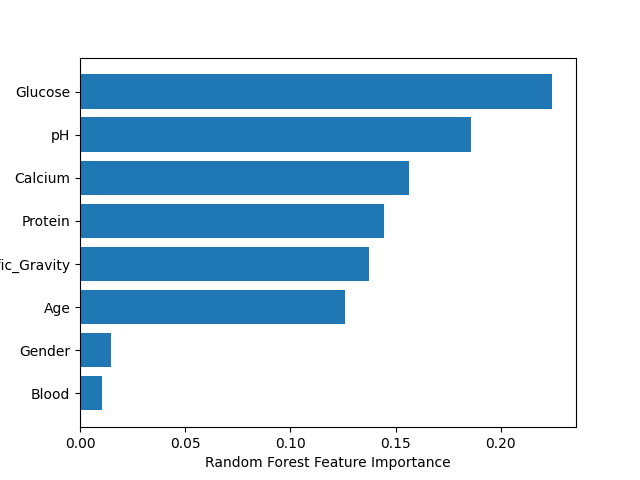

In [ ]:
clf.plot_feature_importance(FEATURE_COLS)

Non-surprisingly (based on data, I don't know about real condition), Gender and Blood almost don't play a role in the classification. The condition seems to be evenly affecting men and women, and Blood is most often absent. Glucose and pH show the most importance. For Glucose I am not surprised due to the earlier EDA and the correlation analysis, however I didn't expect any other feature to gain more importance relative to the others. It seems that Glucose and pH are a good indicator for the condition, perhaps it relates to diabetes?

# SVM

In [ ]:
dataset = Dataset(df, FEATURE_COLS, TARGET_COL[0], NUMERICAL_COLS)

In [ ]:
X, y, X_train, X_test, y_train, y_test = dataset.split_data(impute='knn', n_knn=N_NEIGHBORS)

In [ ]:
class_weight_dict = calc_class_weights(y_train)

In [ ]:
# base model
clf = SVM(class_weight=class_weight_dict, random_state=42)
clf.fit(X_train, y_train,)

In [ ]:
preds = clf.predict(X_test)
y_proba = clf.calc_proba(X_test)

In [ ]:
report(y_test, preds)

              precision    recall  f1-score   support

           0       0.78      0.65      0.71        72
           1       0.36      0.52      0.42        27

    accuracy                           0.62        99
   macro avg       0.57      0.59      0.57        99
weighted avg       0.67      0.62      0.63        99



Not a bad start. The recall is onpar with the Random Forest, but the accuracy overall suffers.

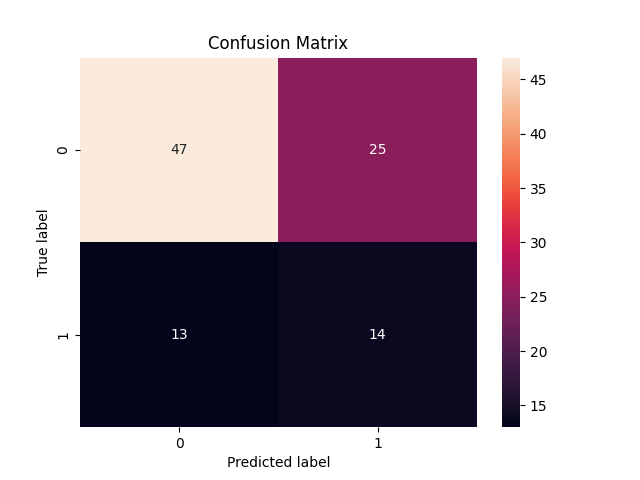

In [ ]:
conf_matrix(y_test, preds, plot=True)

I can see that while learning Condition is similar to previous results, it learns non-Condition worse often marking it as Condition. Perhaps the SVM is overcompensating with such weights.

In [ ]:
plot_roc_curve(y_test, y_proba)

In [ ]:
clf = SVM(class_weight=class_weight_dict, random_state=42)

param_grid = {'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
              'C': [0.01, 0.1, 1, 10, 100],
              'gamma': ['scale', 'auto'],
              'degree': [2, 3, 4, 5],
              'tol': [1e-5, 1e-4, 1e-3, 1e-2],
              'class_weight': ['balanced', None],
              'max_iter': [100, 1000, 3000]
              }

start_time = time.time()
grid_result, grid = clf.cross_validate(param_grid, X_train, y_train,
                                       n_splits=5, verbose=1)
print("Grid search took: ", time.time() - start_time)


Fitting 5 folds for each of 3840 candidates, totalling 19200 fits
Best: 0.585008 using {'C': 10, 'class_weight': 'balanced', 'degree': 2, 'gamma': 'scale', 'kernel': 'sigmoid', 'max_iter': 100, 'tol': 1e-05}
Grid search took:  203.99375009536743


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning:

Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



clf = SVM(class_weight='balanced', random_state=42, C=10, degree=2,
          gamma='scale', kernel='sigmoid', tol=0.0001)

In [ ]:
clf = SVM(class_weight='balanced', random_state=42, C=10, degree=2,
          gamma='scale', kernel='sigmoid', tol=0.00001)
clf.fit(X_train, y_train,)

In [ ]:
preds = clf.predict(X_test)
y_proba = clf.calc_proba(X_test)

In [ ]:
report(y_test, preds)

              precision    recall  f1-score   support

           0       0.74      0.56      0.63        72
           1       0.29      0.48      0.36        27

    accuracy                           0.54        99
   macro avg       0.51      0.52      0.50        99
weighted avg       0.62      0.54      0.56        99



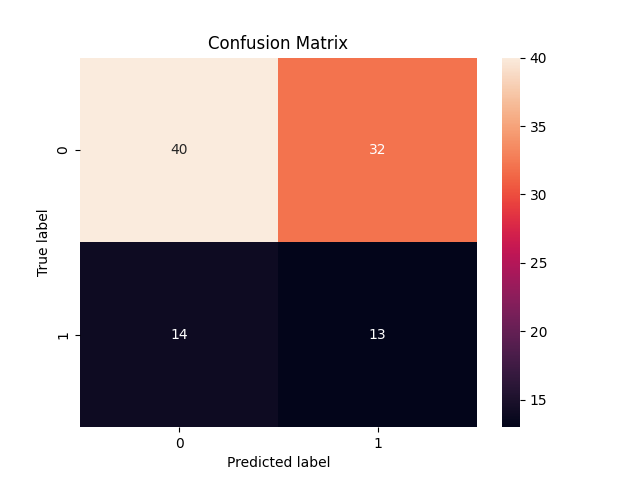

In [ ]:
conf_matrix(y_test, preds, plot=True)

In [ ]:
plot_roc_curve(y_test, y_proba)

The model does much worse with cross-validated grid-searched parameters. This can mean that the base model performs relatively acceptable mainly due a specific data split and is not actually robust.

# A/B test

I will perform A/B test by running the final models on multiple folds and storing the accuracy for each. Then I will do a statistical test on the results to determine whether one of the models is actually better than the other.

In [ ]:
from sklearn.model_selection import cross_val_score
from scipy.stats import ttest_rel, wilcoxon

In [ ]:
rf = RandomForestClassifier(class_weight=class_weight_dict, random_state=42, criterion='gini',
         max_depth=2, min_samples_leaf=10, n_estimators=300)
rf_scores = cross_val_score(
    rf, np.concatenate((X_train, X_test)), np.concatenate((y_train, y_test)),
    cv=30, scoring='f1_macro')

In [ ]:
svm_clf = svm.SVC(class_weight='balanced', random_state=42, C=10, degree=2,
          gamma='scale', kernel='sigmoid', tol=0.00001)
svm_scores = cross_val_score(
    svm_clf, np.concatenate((X_train, X_test)), np.concatenate((y_train, y_test)), cv=30, scoring='f1_macro')

In [ ]:
print("Random Forest")
print("Mean recall: ", rf_scores.mean())
print("Standard deviation: ", rf_scores.std())
print("SVM")
print("Mean recall: ", svm_scores.mean())
print("Standard deviation: ", svm_scores.std())

Random Forest
Mean recall:  0.503554260681263
Standard deviation:  0.1285780824469862
SVM
Mean recall:  0.47963165425980064
Standard deviation:  0.10372435471116997


Text(0.5, 1.0, 'Difference in recall')

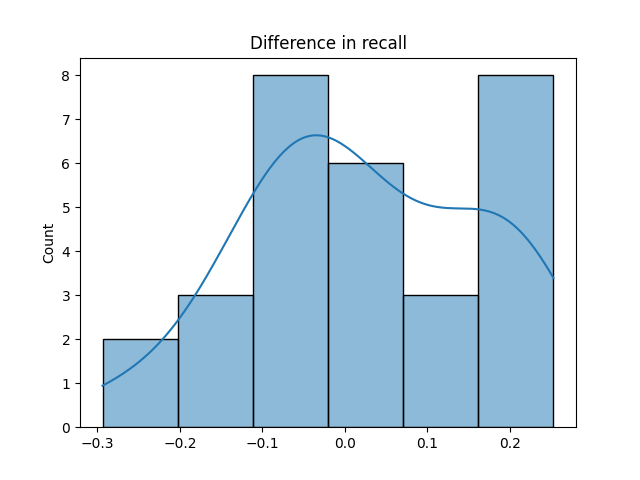

In [ ]:
plt.figure()
sns.histplot(rf_scores-svm_scores, kde=True)
plt.title("Difference in recall")

Very roughly normal, maybe better to use a test not assuming normality.

In [ ]:
t_stat, p_value = wilcoxon(rf_scores, svm_scores)
print(p_value)

0.3817984350025654


Although Random Forest seemed to perform better, it seems there is no actual difference between the two.

# XGBoost

In [ ]:
X, y, X_train, X_test, y_train, y_test = dataset.split_data(impute='knn', n_knn=N_NEIGHBORS)

Training size:  (394, 8)
Test/Validation size:  (99, 8)


In [ ]:
# base model
# due to the imabalnce I always set the weights.
clf = XGB(scale_pos_weight=class_weight_dict[1])
clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)


In [ ]:
preds = clf.predict(X_test)
y_proba = clf.calc_proba(X_test)

In [ ]:
report(y_test, preds)

              precision    recall  f1-score   support

           0       0.77      0.78      0.77        72
           1       0.38      0.37      0.38        27

    accuracy                           0.67        99
   macro avg       0.58      0.57      0.57        99
weighted avg       0.66      0.67      0.66        99



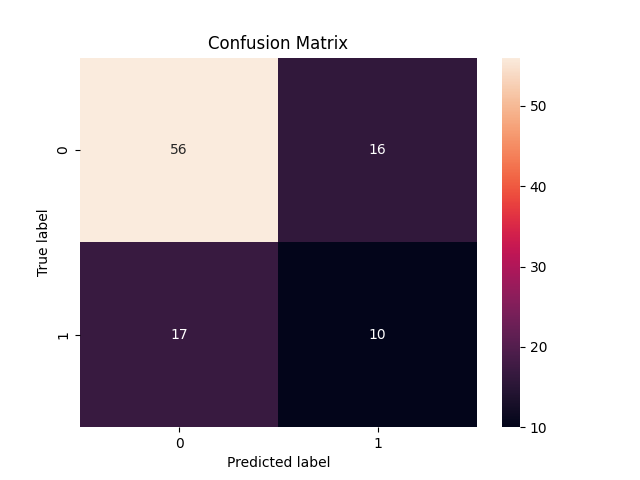

In [ ]:
conf_matrix(y_test, preds, plot=True)

We see many missclassified Condition samples. Despite providing a weight, it did not help the imbalance sufficiently enough.

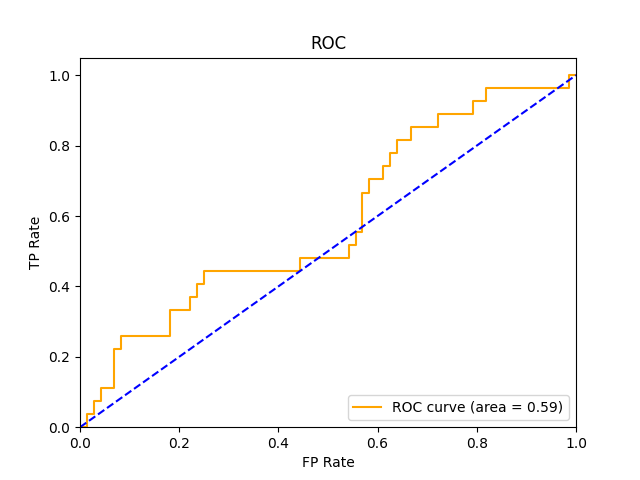

In [ ]:
plot_roc_curve(y_test, y_proba)

The roc curve is not great, close to 0.5. This means that the model doesn't separate well between the classes.

## Cross-Validation for XGBoost

In [ ]:
param_grid = {'scale_pos_weight': [1, 1.5, 2, 2.5],
              'min_child_weight': [5, 10],
              'subsample': [0.85, 1.0],
              'colsample_bytree': [0.8, 0.9, 1.0],
              'max_depth': [2, 3, 5],
              'max_delta_step': [0, 5, 10],
              'eval_metric': ['aucpr', 'logloss'],
              'gamma': [0.5]}

start_time = time.time()
grid_result, grid = clf.cross_validate(param_grid, X_train, y_train,
                                       n_splits=5, scoring='f1', verbose=1)
print("Grid search took: ", time.time() - start_time)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best: 0.141754 using {'eval_metric': 'aucpr'}
Grid search took:  6.942690134048462


In [ ]:
params = grid_result.best_params_.copy()

model = XGB(**params)
model.fit(X_train, y_train)
preds = model.predict(X_test)
y_proba = model.calc_proba(X_test)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)


In [ ]:
report(y_test, preds)

              precision    recall  f1-score   support

           0       0.75      0.88      0.81        72
           1       0.40      0.22      0.29        27

    accuracy                           0.70        99
   macro avg       0.57      0.55      0.55        99
weighted avg       0.65      0.70      0.67        99



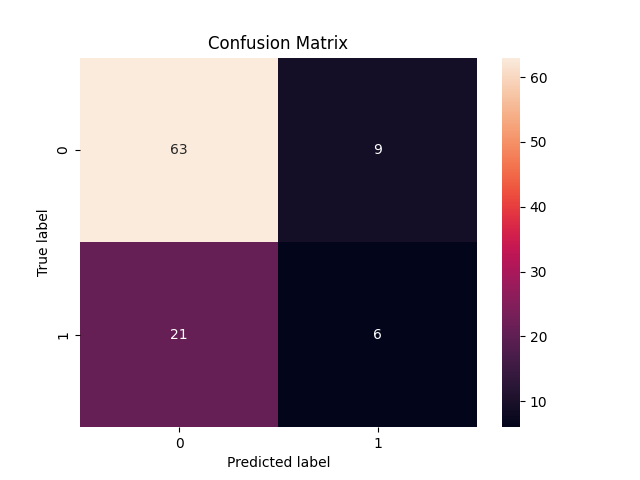

In [ ]:
conf_matrix(y_test, preds, plot=True)

<ipython-input-36-85d2f508e6fb>:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


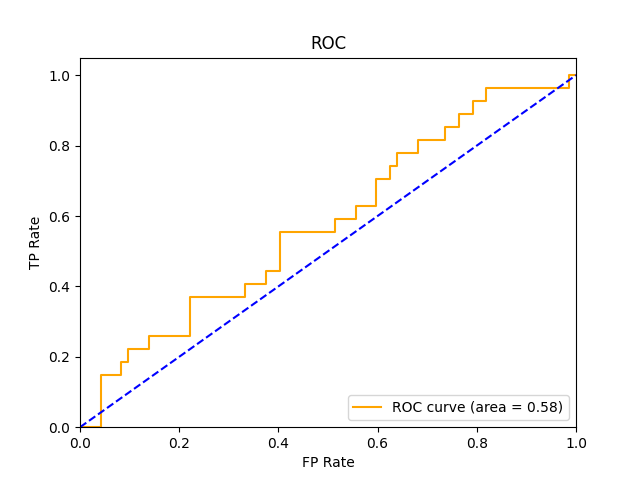

In [ ]:
plot_roc_curve(y_test, y_proba)

Scoring using f1 has given the best result so far. (Best: 0.368285 using {'early_stopping_rounds': 5, 'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 10, 'scale_pos_weight': 2.5, 'subsample': 0.75})

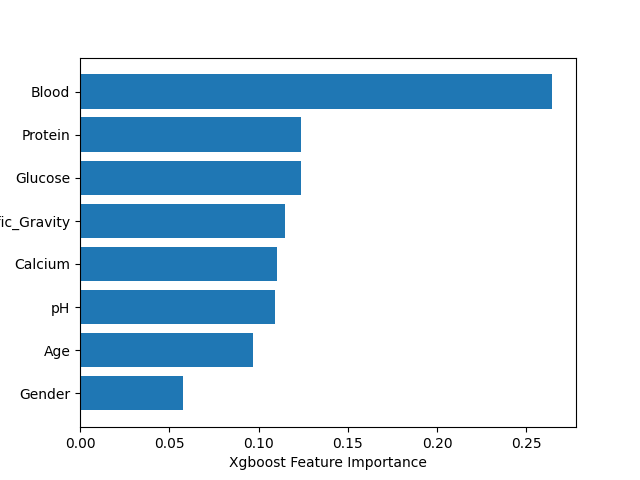

In [ ]:
model.plot_feature_importance()

The feature importance changes a lot depending on the training conditions.

# LGBM

In [ ]:
X, y, X_train, X_test, y_train, y_test = dataset.split_data(impute='knn', n_knn=N_NEIGHBORS)

Training size:  (394, 8)
Test/Validation size:  (99, 8)


In [ ]:
# base model
clf = LGBM(is_unbalance=True, min_data_in_leaf=7)
clf.fit(X_train, y_train)

LGBMClassifier(deterministic=True, is_unbalance=True, min_data_in_leaf=7,
               objective='binary', seed=42, verbose=-1)


In [ ]:
preds = clf.predict(X_test, 0.5)
y_proba = clf.calc_proba(X_test)

In [ ]:
report(y_test, preds)

              precision    recall  f1-score   support

           0       0.78      0.86      0.82        72
           1       0.50      0.37      0.43        27

    accuracy                           0.73        99
   macro avg       0.64      0.62      0.62        99
weighted avg       0.71      0.73      0.71        99



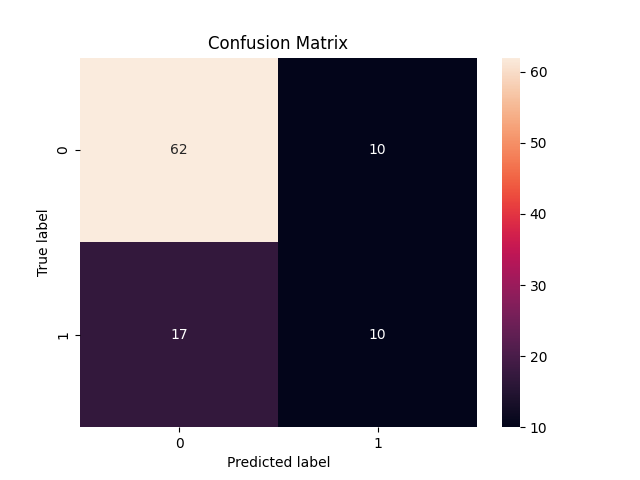

In [ ]:
conf_matrix(y_test, preds, plot=True)

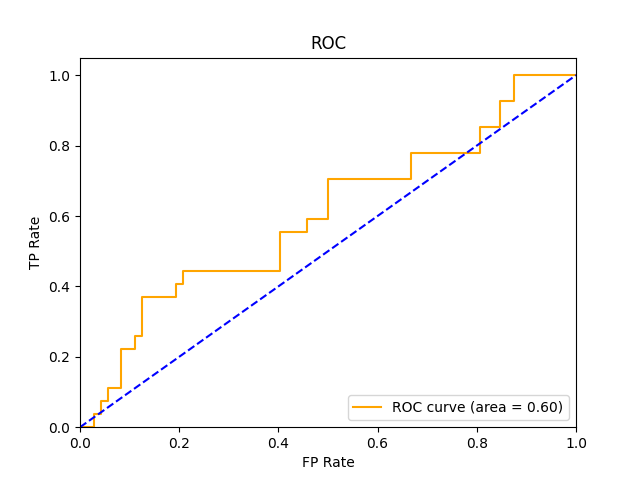

In [ ]:
plot_roc_curve(y_test, y_proba)

In [ ]:
param_grid = {'num_leaves': [20, 30, 50],
              'min_data_in_leaf': [5, 10],
              'max_depth': [1, 2, 3, 5],
              'metric': ['binary', 'f1']}
param_grid = {
              'metric': ['binary', 'f1']}

start_time = time.time()
grid_result, grid = clf.cross_validate(param_grid, X_train, y_train,
                                       n_splits=5, scoring='f1', verbose=1)
print("Grid search took: ", time.time() - start_time)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best: 0.199171 using {'metric': 'binary'}
Grid search took:  4.329503059387207


In [ ]:
params = grid_result.best_params_.copy()

model = LGBM(**params)
model.fit(X_train, y_train)
preds = model.predict(X_test, 0.5)
y_proba = model.calc_proba(X_test)

LGBMClassifier(deterministic=True, metric='binary', objective='binary', seed=42,
               verbose=-1)


In [ ]:
report(y_test, preds)

              precision    recall  f1-score   support

           0       0.78      0.92      0.84        72
           1       0.57      0.30      0.39        27

    accuracy                           0.75        99
   macro avg       0.67      0.61      0.62        99
weighted avg       0.72      0.75      0.72        99



In [ ]:
conf_matrix(y_test, preds)

Confusion Matrix
[[66  6]
 [19  8]]


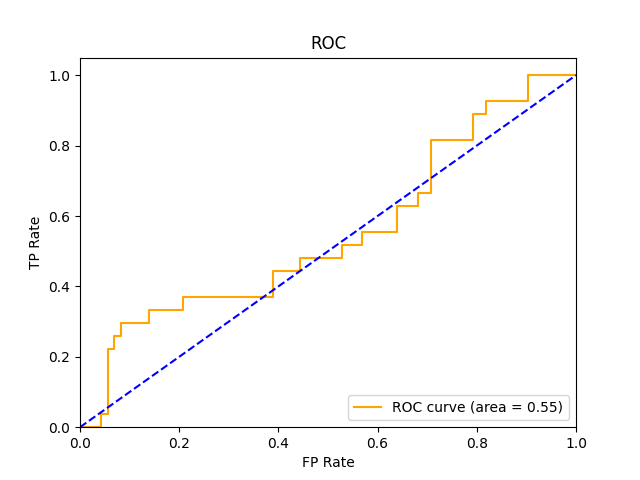

In [ ]:
plot_roc_curve(y_test, y_proba)